# Create General Models
Use this notebook to create the genreal models used to simulate transfer learning for subjects. In this notebook, we will load in the models and data used from the run with highest performance from all subjects **excluding** the subject we are simulating transfer learning for.

Nile Wilson, 2019.03.28

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt
from scipy.fftpack import fft, ifft
from scipy import signal
from mne.filter import filter_data
from statistics import mode

import scipy.signal as scisig
import scipy.io as sio
import numpy as np
import pandas as pd
import datetime
import random
import pickle
import glob
import csv
import mne
import os
import re

## Set Parameters

In [2]:
subjID = 'a1e6c0'
subject_group = 1
EEGdevice = 8
isSVM = False
crossFoldCount = 5

## Function Definitions

Functions for this notebook

In [3]:
def GetBehavioralTL_Direct(behavioralData_all):
    # When the target is to the left
    trialL = np.where(behavioralData_all['target_x'] < 1000)
    movementL = np.where(behavioralData_all['direction_moved'] == 'left')

    # When target was to the right
    trialR = np.where(behavioralData_all['target_x'] > 1000)
    movementR = np.where(behavioralData_all['direction_moved'] == 'right')

    # Create a single list that includes which movement is which (L = 0, R = 1)
    trial_type = np.zeros([1,len(behavioralData_all['score'])])
    trial_type[0][trialL] = 0
    trial_type[0][trialR] = 1
    trial_type = np.round(trial_type[0])

    direction_moved = np.zeros([1,len(behavioralData_all['score'])])
    direction_moved[0][movementL] = 0
    direction_moved[0][movementR] = 1
    direction_moved = np.round(direction_moved[0])
    
    actual = direction_moved
    TL = trial_type
    return actual, TL

Functions for simulating performance just to get scores

In [4]:
def LoadModel_MI(subjID, run_number=0, session_number=1, adaptationType='CS'):
    """
    This function loads the most recent motor imagery classifier
    for this subject by default. Current run minus 1.
    
    You may also select which number model (from original to most recent)
    by using a value from 0 (original) to 4 (most recent)
    """
    runOfInt= run_number
    run_number = runOfInt - 1
    # Load latest model and its associated data
    
    if adaptationType == 'CS' or adaptationType == 'None':
        models = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_*')
        models_data_list = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_*')
    elif adaptationType == 'TL':
        models = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_TL_*')
        models_data_list = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_TL_*')
    
    # Throw exception if model number is outside range of existing models
    if run_number > len(models):
        raise ValueError('Please select a valid model number')
    if adaptationType == 'TL':
        run_number = -1
    print('run_number: ' + str(run_number))
    model_file = models[run_number] # load the most recent model
    print('Selecting model: ' + model_file)
    clf = pickle.load(open(model_file, 'rb'))

    models_data = models_data_list[run_number] # load the most recent model
    MI_data = np.load(models_data)
    X_loaded = MI_data['X_not_scaled']
    X_loaded_scaled = MI_data['X']
    y_loaded = MI_data['y']
    
    return clf, X_loaded, X_loaded_scaled, y_loaded

In [5]:
def LoadModel_Error(subjID):
    # Load the error detection model and see what featureType it used (frequency or template projections)
    models = glob.glob('Models/' + subjID + '/Session1/' + subjID + '_Error_classifier_*') #always load session1 error
    model_file = models[-1] # load the most recent model
    clf_error = pickle.load(open(model_file, 'rb'))
    print(model_file)
    print(clf_error)

    models_data_list = glob.glob('Models/' + subjID + '/Session1/' + subjID + '_data_for_Error_classifier_*')
    models_data = models_data_list[-1] # load the most recent model
    loaded_data = np.load(models_data)
    featureType = loaded_data['featureType']

    # Load templates if applicable
    error_template = loaded_data['error_template'].tolist()
    correct_template = loaded_data['correct_template'].tolist()
    
    # The data
    X_loaded = loaded_data['X']
    y_loaded = loaded_data['y']
    
    return clf_error, featureType, X_loaded, y_loaded, error_template, correct_template

## Make directories
Make the directories where the model(s) and figures will be stored

In [6]:
try:
    os.makedirs('Models/GeneralModels/excluding_' + subjID)
    os.makedirs('Figures/GeneralModels/excluding_' + subjID)
except:
    print('Directories already exist')

Directories already exist


## Load in Classifiers

### Load Subject Demographics
First get the subject demographics loaded. Note that 'useBehavioral' indicates whether the subject had their data collective with the bug in the experimental code (useBehavioral = 'No') or if they were collected recently after the fix (useBehavioral = 'Yes')

In [7]:
demographics_all = pd.read_csv('subject_demographics.csv')
generalSubjects = list(demographics_all['Subject ID'])
demographics_all.head()

,Subject ID,Group Number,Moving MI,Session 1,Session 2,Session 3,Handedness,Sex,Age,History of Neurological Disorders,Cap Size,useBehavioral
0,b12a46,1,No,0,8,15,R,M,21,No,M,No
1,41d8ff,1,No,0,5,12,R,F,21,No,M,No
2,1e8b34,1,No,0,3,14,R,M,29,No,L,No
3,ad11cf,1,No,0,7,12,R,F,20,Yes,M,No
4,b7ff16,2,No,0,19,21,R,F,20,No,M,No


In [8]:
# Remove the subject of interest
demo = demographics_all.copy()
demo.drop(demo.loc[demo['Subject ID'] == subjID].index[0])
demo.head()

,Subject ID,Group Number,Moving MI,Session 1,Session 2,Session 3,Handedness,Sex,Age,History of Neurological Disorders,Cap Size,useBehavioral
0,b12a46,1,No,0,8,15,R,M,21,No,M,No
1,41d8ff,1,No,0,5,12,R,F,21,No,M,No
2,1e8b34,1,No,0,3,14,R,M,29,No,L,No
3,ad11cf,1,No,0,7,12,R,F,20,Yes,M,No
4,b7ff16,2,No,0,19,21,R,F,20,No,M,No


In [9]:
generalSubjects = list(demo['Subject ID'])

### Load in the Classifiers
Load in the Motor Imagery classifiers, and their data, which were used during the highest performance run for each subject. Also load in the respective error classifier for each subjects. Note: there was only one error classifier per subject so we do not need to try and find this by run of best performance.

In [10]:
# Load most recent performance data file
# There should only be one in the end (but making many for testing now)
data_files = glob.glob('2019*_all_scores_for_2-way_ANOVA_sessions.sav.mat')
filename = data_files[-1]
print('Selecting performance data file: ' + filename)

# Load the contents
mat_contents = sio.loadmat(filename)

scores = mat_contents['all_scores_export'][0]
adaptation_scheme = mat_contents['AdaptationScheme']
session_number = list()
run_number = list()
subject = mat_contents['Subject']

# handedness = mat_contents['Handedness']
# age = mat_contents['Age'][0]

# Remove excess white space and convert session and run num to numbers
for i in range(0,len(adaptation_scheme)):
    adaptation_scheme[i] = adaptation_scheme[i].strip()
    session_number.append(int(re.sub("[^0-9]", "", mat_contents['SessionNumber'][i])))
    run_number.append(int(re.sub("[^0-9]", "", mat_contents['RunNumber'][i])))
    
session_number = np.asarray(session_number)
run_number = np.asarray(run_number)

Selecting performance data file: 2019-03-29-17-25-46_all_scores_for_2-way_ANOVA_sessions.sav.mat


Get the run and session number containing the max score for each subject

# REMOVE THE [0:10]
The range is just there to prevent running on subjects where we don't have the data yet

In [11]:
max_scores = list()
max_runs = list()
max_sessions = list()
all_clf = list()
all_X_loaded = list()
all_X_loaded_scaled = list()
all_y_loaded = list()
error_clf = list()
error_X_loaded = list()
error_y_loaded = list()
error_featureType = list()
error_error_template = list()
error_correct_template = list()

for subjOfInt in generalSubjects[0:10]:

    # Find original scores ('co-adaptation' or 'no adaptation')
    a = np.where(subject==subjOfInt)[0]
    b = np.where(adaptation_scheme=='co-adaptation')[0]
    c = np.where(adaptation_scheme=='no adaptation')[0]
    ab = list(set(a) & set(b)) # finding common row numbers
    ac = list(set(a) & set(c))

    if not ab:
        print('ab empty')
        toUse = ac
        adaptationType = 'None'
    if not ac:
        print('ac empty')
        toUse = ab
        adaptationType = 'CS'
    toUse.sort()
    
    max_score = np.max(scores[toUse])
    max_idx = np.argmax(scores[toUse])
    max_run = run_number[toUse][max_idx]
    max_session = session_number[toUse][max_idx]
    
    # Add to list
    max_scores.append(max_score)
    max_runs.append(max_run)
    max_sessions.append(max_session)
    
    # Load the MI model that led to max score
    clf, X_loaded, X_loaded_scaled, y_loaded = LoadModel_MI(subjOfInt, run_number=max_run,
                                                            session_number=max_session,
                                                            adaptationType=adaptationType)
    all_clf.append(clf)
    all_X_loaded.append(X_loaded)
    all_X_loaded_scaled.append(X_loaded_scaled)
    all_y_loaded.append(y_loaded)
    
    # Load in the error model
    clf_error, featureType, X_loaded, y_loaded, error_template, correct_template = LoadModel_Error(subjOfInt)
    error_clf.append(clf_error)
    error_featureType.append(featureType)
    error_X_loaded.append(X_loaded)
    error_y_loaded.append(y_loaded)
    error_error_template.append(error_template)
    error_correct_template.append(correct_template)

ab empty
run_number: 1
Selecting model: Models/b12a46/Session2\b12a46_MI_classifier_2019-02-21-12-32-38.sav
Models/b12a46/Session1\b12a46_Error_classifier_2019-02-06-10-23-55.sav
MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
ab empty
run_number: 0
Selecting model: Models/41d8ff/Session2\41d8ff_MI_classifier_2019-02-13-16-26-08.sav
Models/41d8ff/Session1\41d8ff_Error_classifier_2019-02-08-11-36-57.sav
MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant

## Create general models
Use the loaded data to create a general MI classifier and a general error classifier which will be tested on the subject of interest

### Train general MI classifier using multiple subject data

In [12]:
# Concatenate all data
X_not_scaled_MI = np.vstack(all_X_loaded)
X_MI = np.vstack(all_X_loaded_scaled)
y_MI = np.concatenate(all_y_loaded)

print(np.shape(X_MI))
print(np.shape(y_MI))

# preprocess dataset, split into training and test part
args = np.arange(len(X_MI))
np.random.shuffle(args)
X_not_scaled_MI = [X_not_scaled_MI[i] for i in args]
X_MI = [X_MI[i] for i in args]
y_MI = [y_MI[i] for i in args]

# Resample to account for imbalance
method = SMOTE(kind='regular')
X_MI, y_MI = method.fit_sample(X_MI, y_MI)

if isSVM is True:
    # Determine model parameters
    Cs = [0.001, 0.01, 0.1, 1, 1.5, 2, 5]
    degrees = [1, 2, 3, 4, 5]
    hyper_params = {"C":Cs, "degree":degrees}
    grid = GridSearchCV(SVC(kernel='rbf', gamma='auto'), param_grid=hyper_params, cv=KFold(n_splits=crossFoldCount), verbose=True)
else:
    # Determine model parameters
    activations = ['relu','tanh']
    alphas = np.logspace(-6, 3, 10)
    solvers = ['lbfgs','sgd']
    hyper_params = {"activation":activations, "alpha":alphas, "solver":solvers}
    grid = GridSearchCV(MLPClassifier(learning_rate='constant', random_state=1), param_grid=hyper_params, cv=KFold(n_splits=crossFoldCount), verbose=True)

X_train, X_test, y_train, y_test = train_test_split(X_MI, y_MI, test_size=0.3)

# Fit the model
grid.fit(X_MI, y_MI)
grid.best_estimator_
clf = grid.best_estimator_
clf.fit(X_train,y_train)

(10650, 4)
(10650,)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.7min finished


MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

Validate

In [13]:
print('Score: ' + str(clf.score(X_test, y_test)))

Score: 0.5651358950328023


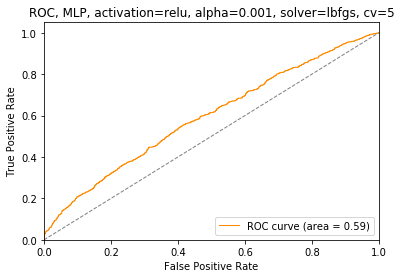

In [14]:
# Get values
if isSVM is True:
    y_score = clf.fit(X_train, y_train).decision_function(X_test)
else:
    y_score = clf.predict_proba(X_test)
    y_score = y_score[:,1]
fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)

# Plot the ROC
fig = plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
if isSVM is True:
    plt.title('ROC, ' + clf.kernel + ' kernel, deg=' + str(clf.degree) + ', C=' + str(clf.C) + ', cv=' + str(crossFoldCount))
else:
    plt.title('ROC, MLP, activation=' + str(clf.activation) + ', alpha=' + str(clf.alpha) + ', solver=' + str(clf.solver)
             + ', cv=' + str(crossFoldCount))
lgd = plt.legend(loc="lower right")
plt.show()

if isSVM is True:
    fig.savefig('Figures/GeneralModels/excluding_' + subjID + '/ROC_SVM.png', bbox_extra_artists=(lgd,))
else:
    fig.savefig('Figures/GeneralModels/excluding_' + subjID + '/ROC.png', bbox_extra_artists=(lgd,))

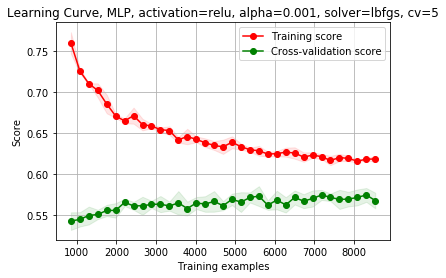

In [15]:
fig = plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes = np.linspace(0.1, 1, num=35)
train_sizes, train_scores, test_scores = learning_curve(clf, X_MI, y_MI,
                                                        train_sizes=train_sizes, cv=crossFoldCount)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
if isSVM is True:
    plt.title('Learning Curve, ' + clf.kernel + ' kernel, deg=' + str(clf.degree) + ', C=' + str(clf.C) + ', cv=' + str(crossFoldCount))
    fig.savefig('Figures/GeneralModels/excluding_' + subjID + '/Learning-Curve_SVM.png', bbox_extra_artists=(lgd,))
else:
    plt.title('Learning Curve, MLP, activation=' + str(clf.activation) + ', alpha=' + str(clf.alpha) + ', solver=' + str(clf.solver) + ', cv=' + str(crossFoldCount))
    fig.savefig('Figures/GeneralModels/excluding_' + subjID + '/Learning-Curve.png', bbox_extra_artists=(lgd,))

Use a grid search to figure out the model parameters

In [16]:
# Store as clf_MI
clf_MI = clf

### Train general error classifier

First get the most common parameters

In [17]:
"""
# Find the most common of all parameters
all_activation = list()
all_alpha = list()
all_batch_size = list()
all_beta_1 = list()
all_beta_2 = list()
all_early_stopping = list()
all_epsilon = list()
all_hidden_layer_sizes = list()
all_learning_rate = list()
all_learning_rate_init = list()
all_max_iter = list()
all_momentum = list()
all_n_iter_no_change = list()
all_nesterovs_momentum = list()
all_power_t = list()
all_random_state = list()
all_shuffle = list()
all_solver = list()
all_tol = list()
all_validation_fraction = list()
all_verbose = list()
all_warm_start = list()

for i in range(0,len(error_clf)):
    all_activation.append(error_clf[i].activation)
    all_alpha.append(error_clf[i].alpha)
    all_batch_size.append(error_clf[i].batch_size)
    all_beta_1.append(error_clf[i].beta_1)
    all_beta_2.append(error_clf[i].beta_2)
    all_early_stopping.append(error_clf[i].early_stopping)
    all_epsilon.append(error_clf[i].epsilon)
    all_hidden_layer_sizes.append(error_clf[i].hidden_layer_sizes)
    all_learning_rate.append(error_clf[i].learning_rate)
    all_learning_rate_init.append(error_clf[i].learning_rate_init)
    all_max_iter.append(error_clf[i].max_iter)
    all_momentum.append(error_clf[i].momentum)
    all_n_iter_no_change.append(error_clf[i].n_iter_no_change)
    all_nesterovs_momentum.append(error_clf[i].nesterovs_momentum)
    all_power_t.append(error_clf[i].power_t)
    all_random_state.append(error_clf[i].random_state)
    all_shuffle.append(error_clf[i].shuffle)
    all_solver.append(error_clf[i].solver)
    all_tol.append(error_clf[i].tol)
    all_validation_fraction.append(error_clf[i].validation_fraction)
    all_verbose.append(error_clf[i].verbose)
    all_warm_start.append(error_clf[i].warm_start)

# Create catch for mode
def mode2(x):
    try:
        y = mode(x)
    except:
        print('No mode, so chosing at random')
        y = random.choice(x)
    return y

# Save the most common ones
activation = mode2(all_activation)
alpha = mode2(all_alpha)
batch_size = mode2(all_batch_size)
beta_1 = mode2(all_beta_1)
beta_2 = mode2(all_beta_2)
early_stopping = mode2(all_early_stopping)
epsilon = mode2(all_epsilon)
hidden_layer_sizes = mode2(all_hidden_layer_sizes)
learning_rate = mode2(all_learning_rate)
learning_rate_init = mode2(all_learning_rate_init)
max_iter = mode2(all_max_iter)
momentum = mode2(all_momentum)
n_iter_no_change = mode2(all_n_iter_no_change)
nesterovs_momentum = mode2(all_nesterovs_momentum)
power_t = mode2(all_power_t)
random_state = mode2(all_random_state)
shuffle = mode2(all_shuffle)
solver = mode2(all_solver)
tol = mode2(all_tol)
validation_fraction = mode2(all_validation_fraction)
verbose = mode2(all_verbose)
warm_start = mode2(all_warm_start)
"""

"\n# Find the most common of all parameters\nall_activation = list()\nall_alpha = list()\nall_batch_size = list()\nall_beta_1 = list()\nall_beta_2 = list()\nall_early_stopping = list()\nall_epsilon = list()\nall_hidden_layer_sizes = list()\nall_learning_rate = list()\nall_learning_rate_init = list()\nall_max_iter = list()\nall_momentum = list()\nall_n_iter_no_change = list()\nall_nesterovs_momentum = list()\nall_power_t = list()\nall_random_state = list()\nall_shuffle = list()\nall_solver = list()\nall_tol = list()\nall_validation_fraction = list()\nall_verbose = list()\nall_warm_start = list()\n\nfor i in range(0,len(error_clf)):\n    all_activation.append(error_clf[i].activation)\n    all_alpha.append(error_clf[i].alpha)\n    all_batch_size.append(error_clf[i].batch_size)\n    all_beta_1.append(error_clf[i].beta_1)\n    all_beta_2.append(error_clf[i].beta_2)\n    all_early_stopping.append(error_clf[i].early_stopping)\n    all_epsilon.append(error_clf[i].epsilon)\n    all_hidden_layer

Save all templates and decide which ones to use when testing with the individual subject (will need to restrict by cap size because that effects the montage)

In [18]:
"""
featureTypes = list()
for i in range(0,len(error_clf)):
    featureTypes.append(str(error_featureType[i]))
featureType = mode(featureTypes)

error_templates = error_error_template
correct_templates = error_correct_template
"""

'\nfeatureTypes = list()\nfor i in range(0,len(error_clf)):\n    featureTypes.append(str(error_featureType[i]))\nfeatureType = mode(featureTypes)\n\nerror_templates = error_error_template\ncorrect_templates = error_correct_template\n'

Then create the classifier

In [19]:
"""
# Create using parameters
clf_error = MLPClassifier(activation=activation, alpha=alpha, batch_size=batch_size, beta_1=beta_1,
                   beta_2=beta_2, early_stopping=early_stopping, epsilon=epsilon,
                   hidden_layer_sizes=hidden_layer_sizes, learning_rate=learning_rate,
                   learning_rate_init=learning_rate_init, max_iter=max_iter, momentum=momentum,
                   n_iter_no_change=n_iter_no_change, nesterovs_momentum=nesterovs_momentum, power_t=power_t,
                   random_state=random_state, shuffle=shuffle, solver=solver, tol=tol,
                   validation_fraction=validation_fraction, verbose=verbose, warm_start=warm_start)
clf_error
"""

'\n# Create using parameters\nclf_error = MLPClassifier(activation=activation, alpha=alpha, batch_size=batch_size, beta_1=beta_1,\n                   beta_2=beta_2, early_stopping=early_stopping, epsilon=epsilon,\n                   hidden_layer_sizes=hidden_layer_sizes, learning_rate=learning_rate,\n                   learning_rate_init=learning_rate_init, max_iter=max_iter, momentum=momentum,\n                   n_iter_no_change=n_iter_no_change, nesterovs_momentum=nesterovs_momentum, power_t=power_t,\n                   random_state=random_state, shuffle=shuffle, solver=solver, tol=tol,\n                   validation_fraction=validation_fraction, verbose=verbose, warm_start=warm_start)\nclf_error\n'

In [20]:
"""
# Concatenate all data
X_error = np.vstack(error_X_loaded)
y_error = np.concatenate(error_y_loaded)

print(np.shape(X_error))
print(np.shape(y_error))

# preprocess dataset, split into training and test part
args = np.arange(len(X_error))
np.random.shuffle(args)
X_error = [X_error[i] for i in args]
y_error = [y_error[i] for i in args]

# Resample to account for imbalance
method = SMOTE(kind='regular')
X_error, y_error = method.fit_sample(X_error, y_error)

# Train on all data
clf_error.fit(X_error, y_error)
"""

"\n# Concatenate all data\nX_error = np.vstack(error_X_loaded)\ny_error = np.concatenate(error_y_loaded)\n\nprint(np.shape(X_error))\nprint(np.shape(y_error))\n\n# preprocess dataset, split into training and test part\nargs = np.arange(len(X_error))\nnp.random.shuffle(args)\nX_error = [X_error[i] for i in args]\ny_error = [y_error[i] for i in args]\n\n# Resample to account for imbalance\nmethod = SMOTE(kind='regular')\nX_error, y_error = method.fit_sample(X_error, y_error)\n\n# Train on all data\nclf_error.fit(X_error, y_error)\n"

## Save

Save the MI model

In [21]:
if isSVM is True:
    model_file = 'Models/General_Model_MI_excluding_' + subjID + '_SVM.sav'
    filepath_export_data = 'Models/Data_for_General_MI_classifier_excluding_' + subjID + '_SVM.npz'
else:
    model_file = 'Models/General_Model_MI_excluding_' + subjID + '.sav'
    filepath_export_data = 'Models/Data_for_General_MI_classifier_excluding_' + subjID + '.npz'

    pickle.dump(clf_MI, open(model_file, 'wb'))
np.savez_compressed(filepath_export_data, X=X_MI, X_not_scaled=X_not_scaled_MI, y=y_MI)

And save the error model (saving all error and correct templates)

In [22]:
"""
if isSVM is True:
    model_file = 'Models/General_Model_error_excluding_' + subjID + '_SVM.sav'
    filepath_export_data = 'Models/Data_for_General_error_classifier_excluding_' + subjID + '_SVM.npz'
else:
    model_file = 'Models/General_Model_error_excluding_' + subjID + '.sav'
    filepath_export_data = 'Models/Data_for_General_error_classifier_excluding_' + subjID + '.npz'

pickle.dump(clf_error, open(model_file, 'wb'))
np.savez_compressed(filepath_export_data, X=X_error, y=y_error, featureType=featureType, error_templates=error_templates, correct_templates=correct_templates)
"""

"\nif isSVM is True:\n    model_file = 'Models/General_Model_error_excluding_' + subjID + '_SVM.sav'\n    filepath_export_data = 'Models/Data_for_General_error_classifier_excluding_' + subjID + '_SVM.npz'\nelse:\n    model_file = 'Models/General_Model_error_excluding_' + subjID + '.sav'\n    filepath_export_data = 'Models/Data_for_General_error_classifier_excluding_' + subjID + '.npz'\n\npickle.dump(clf_error, open(model_file, 'wb'))\nnp.savez_compressed(filepath_export_data, X=X_error, y=y_error, featureType=featureType, error_templates=error_templates, correct_templates=correct_templates)\n"

## Test on subject
In another notebook, simulate how the subject would perform using the general models and compare to how they actually did

Compare to how they actually did during data collection